# Analyzing Box Office Trends: Insights for Film Production


### 1.1. Project Objective
The goal of this project is to analyze various aspects of movie performance to provide actionable insights for a new movie studio. This analysis will help identify which genres, budgets, and other factors are associated with higher box office success.

### 1.2. Data Description
- movie_basics: Contains basic information about movies, including titles, release years, and genres.
- movie_ratings: Includes IMDb ratings and the number of votes for each movie.
- bom.movie_gross.csv.gz: Contains box office gross information for movies.

### 1.3. Suitability of Data
The datasets cover various aspects of movies including financials, reviews, and basic information, making them highly suitable for a comprehensive analysis.

## 2. Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nbconvert


In [2]:
# Load box office data
box_office_gross = pd.read_csv('C:/Users/USER/Desktop/ble/zippedData/bom.movie_gross.csv.gz')

# Connect to the SQL database
db_path = 'C:/Users/USER/Desktop/ble/zippedData/im.db'
conn = sqlite3.connect(db_path)


In [3]:
# Load the relevant tables into DataFrames
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
conn.close()

In [4]:
# Displaying summaries of the datasets
print("Movie Basics Summary:")
print(movie_basics.describe(include='all'))
print("\nMovie Ratings Summary:")
print(movie_ratings.describe())
print("\nBox Office Gross Summary:")
print(box_office_gross.describe(include='all'))

Movie Basics Summary:
         movie_id primary_title original_title     start_year  \
count      146144        146144         146123  146144.000000   
unique     146144        136071         137773            NaN   
top     tt9914662          Home         Broken            NaN   
freq            1            24             19            NaN   
mean          NaN           NaN            NaN    2014.621798   
std           NaN           NaN            NaN       2.733583   
min           NaN           NaN            NaN    2010.000000   
25%           NaN           NaN            NaN    2012.000000   
50%           NaN           NaN            NaN    2015.000000   
75%           NaN           NaN            NaN    2017.000000   
max           NaN           NaN            NaN    2115.000000   

        runtime_minutes       genres  
count     114405.000000       140736  
unique              NaN         1085  
top                 NaN  Documentary  
freq                NaN        32185  
me

### 2.1. Data Limitations
 - Incomplete Data: Some movies may not have complete financial data, such as missing gross revenues. These are filled with 0s, which could underestimate the actual revenue.
 -  Duplicate Titles: Movies with the same title but different 'movie_id' are considered distinct entries. This could affect genre and revenue analysis if not appropriately addressed.
-  Genre Overlap: Movies often belong to multiple genres, complicating the analysis of which genres perform best. We address this by exploding the genres column but acknowledge that it may dilute the impact of any single genre.
- Budget Categories: The categorization of budget into 'Low', 'Medium', and 'High' is somewhat arbitrary and may not capture the nuances of actual budget ranges.
- Rating Bias: Ratings are subjective and can vary across platforms. The dataset's ratings may not be representative of all audience opinions.

## 3. Data Cleaning and Preparation

### 3.1. Data Normalization and Merging

In [5]:
# Normalize movie titles by converting to lowercase
movie_basics['primary_title'] = movie_basics['primary_title'].str.lower()
box_office_gross['title'] = box_office_gross['title'].str.lower()

In [6]:
# Merge datasets on movie titles
merged_data = pd.merge(movie_basics, movie_ratings, on='movie_id', how='inner')
merged_data = pd.merge(merged_data, box_office_gross, left_on='primary_title', right_on='title', how='inner')


In [7]:
# Handle missing values in 'runtime_minutes' by imputing with the mean
mean_runtime = merged_data['runtime_minutes'].mean()
merged_data['runtime_minutes'] = merged_data['runtime_minutes'].fillna(mean_runtime)


In [8]:
# Replace missing 'studio' values with 'Unknown'
merged_data['studio'] = merged_data['studio'].fillna('Unknown')

In [9]:
# Drop redundant column `year`
merged_data.drop(columns='year', inplace=True)

In [10]:
merged_data['genres'] 

0            Action,Crime,Drama
1       Adventure,Drama,Romance
2        Adventure,Comedy,Drama
3            Action,Crime,Drama
4       Action,Adventure,Sci-Fi
                 ...           
3128               Comedy,Drama
3129     Action,Sci-Fi,Thriller
3130                      Drama
3131               Action,Drama
3132                Documentary
Name: genres, Length: 3133, dtype: object

In [11]:
# Clean and convert gross columns
merged_data['foreign_gross'] = merged_data['foreign_gross'].astype(str).str.replace(r'[$,]', '', regex=True).str.replace('nan', '', regex=False)
merged_data['foreign_gross'] = pd.to_numeric(merged_data['foreign_gross'], errors='coerce').fillna(0)
merged_data['domestic_gross'] = merged_data['domestic_gross'].astype(str).str.replace(r'[$,]', '', regex=True).str.replace('nan', '', regex=False)
merged_data['domestic_gross'] = pd.to_numeric(merged_data['domestic_gross'], errors='coerce').fillna(0)

### 3.2. Update Specific Movie Genres

In [12]:
# Define the genres for the specified movies as seen on imdb website
genre_updates = {
    "tt6858500": "Action, Adventure, Drama",  # Robin Hood
    "tt1472211": "Action, Comedy, Romance",   # The Bounty Hunter
    "tt6135412": "Comedy, Romance",           # Going the Distance
    "tt1701997": "Comedy, Drama, Music",      # I'm Still Here
    "tt6814096": "Drama, Thriller",           # When the Bough Breaks
    "tt2495188": "Biography, Drama",          # Joy
    "tt1636456": "Comedy, Drama"              # The Intern
}

# Update the genres for the specified movies
merged_data['genres'] = merged_data.apply(
    lambda row: genre_updates[row['movie_id']] if row['movie_id'] in genre_updates else row['genres'],
    axis=1
)


In [13]:
merged_data['genres']

0            Action,Crime,Drama
1       Adventure,Drama,Romance
2        Adventure,Comedy,Drama
3            Action,Crime,Drama
4       Action,Adventure,Sci-Fi
                 ...           
3128               Comedy,Drama
3129     Action,Sci-Fi,Thriller
3130                      Drama
3131               Action,Drama
3132                Documentary
Name: genres, Length: 3133, dtype: object

In [14]:
# Filter for rows with 'unknown' genre (case-insensitive)
unknown_genres_data = merged_data[merged_data['genres'].astype(str).str.lower() == 'unknown']

# Print the filtered data
if unknown_genres_data.empty:
    print("No rows found with 'unknown' genre.")
else:
    print(unknown_genres_data)

No rows found with 'unknown' genre.


In [15]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3133 entries, 0 to 3132
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3133 non-null   object 
 1   primary_title    3133 non-null   object 
 2   original_title   3133 non-null   object 
 3   start_year       3133 non-null   int64  
 4   runtime_minutes  3133 non-null   float64
 5   genres           3133 non-null   object 
 6   averagerating    3133 non-null   float64
 7   numvotes         3133 non-null   int64  
 8   title            3133 non-null   object 
 9   studio           3133 non-null   object 
 10  domestic_gross   3133 non-null   float64
 11  foreign_gross    3133 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 293.8+ KB


### 3.3. Feature Engineering

In [16]:
# Define budget thresholds
low_budget_threshold = 10000000  # $10 million
high_budget_threshold = 100000000  # $100 million

# Create budget categories based on gross revenue
merged_data['budget_category'] = pd.cut(merged_data['domestic_gross'] + merged_data['foreign_gross'],
                                       bins=[-float('inf'), low_budget_threshold, high_budget_threshold, float('inf')],
                                       labels=['Low', 'Medium', 'High'])

# Calculate total gross
merged_data['total_gross'] = merged_data['domestic_gross'] + merged_data['foreign_gross']

# Split genres into separate rows
merged_data['genres'] = merged_data['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
merged_data = merged_data.explode('genres')
merged_data['genres'] = merged_data['genres'].str.strip().str.title()


## 4. Exploratory Data Analysis (EDA)

### Genre Analysis

### 4.1. What are the most lucrative genres?

In [17]:
# Group data by genre and calculate total gross and average revenue
genre_analysis = merged_data.groupby('genres').agg({
    'total_gross': 'sum',
    'movie_id': 'count'
})
genre_analysis['average_revenue'] = genre_analysis['total_gross'] / genre_analysis['movie_id']
genre_analysis.sort_values(by='average_revenue', ascending=False, inplace=True)

#### Visualization: Top 10 Movie Genres by Average Box Office Revenue

C:\Users\USER\AppData\Local\Temp\ipykernel_3752\405178410.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


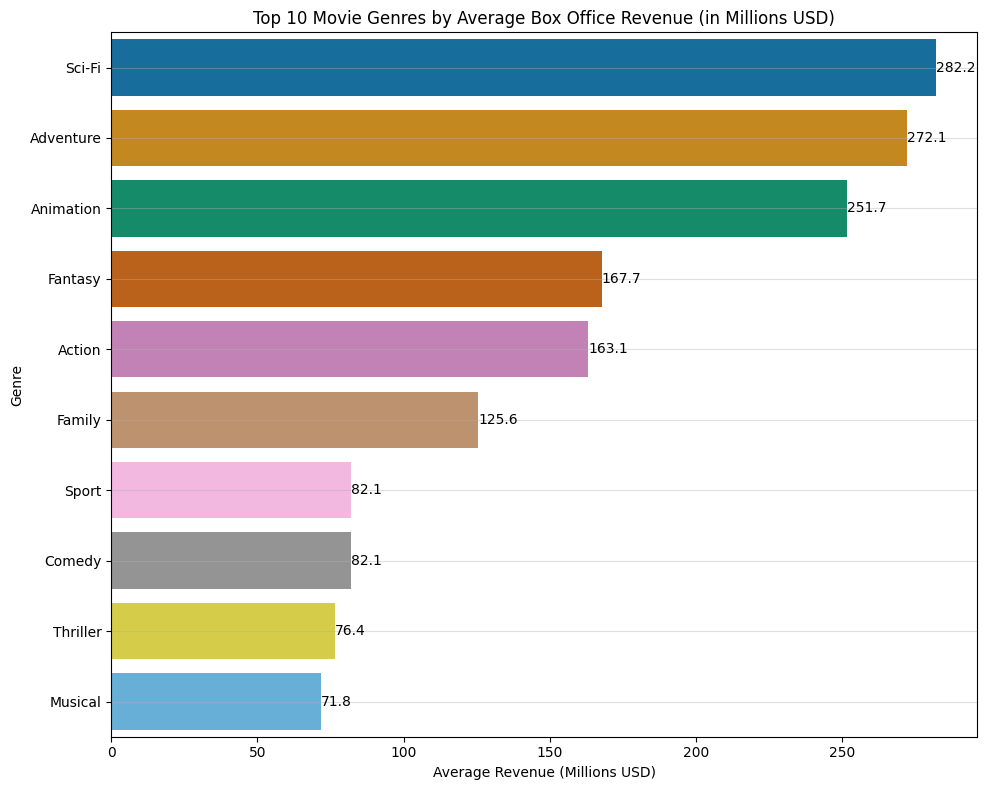

In [18]:
# Plot the top 10 genres by average revenue
top_10_genres = genre_analysis.head(10)
plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_10_genres['average_revenue'] / 1e6,  # Revenue in millions
    y=top_10_genres.index,
    palette="colorblind"
)
plt.title("Top 10 Movie Genres by Average Box Office Revenue (in Millions USD)")
plt.xlabel("Average Revenue (Millions USD)")
plt.ylabel("Genre")
plt.grid(axis="y", alpha=0.4)

# Data labels
for i, v in enumerate(top_10_genres['average_revenue']):
    plt.text(v / 1e6, i, f"{v/1e6:.1f}", ha="left", va="center")

plt.tight_layout()
plt.show()

### 4.2. Which genres generate the most domestic and foreign revenue?

In [19]:
# Group data by genre and calculate total domestic and foreign gross
gross_data = merged_data.groupby('genres')[['domestic_gross', 'foreign_gross']].sum()
top_gross_data = gross_data.loc[top_10_genres.index]

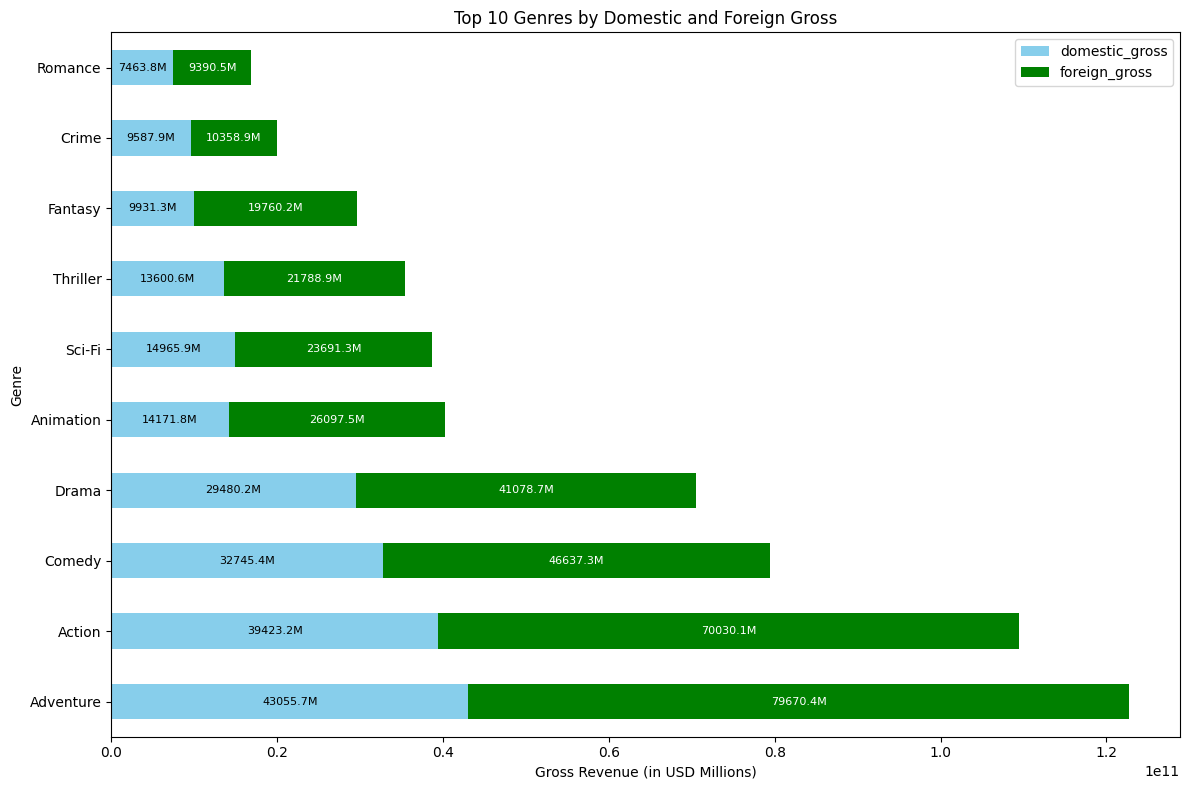

In [20]:


# Select the top 10 genres based on the sum of domestic and foreign gross
top_gross_data = gross_data.sum(axis=1).nlargest(10).index
top_gross_data = gross_data.loc[top_gross_data]

# Set up colors for the bars
colors = {'domestic_gross': 'skyblue', 'foreign_gross': 'green'}

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
top_gross_data.plot(kind='barh', stacked=True, color=colors, ax=ax)

# Add labels and title
ax.set_xlabel('Gross Revenue (in USD Millions)')
ax.set_ylabel('Genre')
ax.set_title('Top 10 Genres by Domestic and Foreign Gross')


# Adding text labels for domestic and foreign gross with formatting (Millions)
for i, genre in enumerate(top_gross_data.index):
    domestic = top_gross_data.at[genre, 'domestic_gross']
    foreign = top_gross_data.at[genre, 'foreign_gross']
    total = domestic + foreign

    ax.text(domestic / 2, i, f'{domestic/1e6:.1f}M', va='center', ha='center', color='black', fontsize=8)
    ax.text(total - foreign / 2, i, f'{foreign/1e6:.1f}M', va='center', ha='center', color='white', fontsize=8)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Show the plot
plt.show()

Foreign Gross Dominance:

For all genres, the foreign gross revenue exceeds the domestic gross revenue.
The difference is particularly large for genres like Adventure, Action, and Animation.
Top Grossing Genres:

Adventure and Action are the highest-grossing genres, with Adventure leading in both domestic and foreign markets.
These genres have gross revenues close to and exceeding 1.2e11 (120 billion USD) when combined.
Other High Grossing Genres:

Comedy and Drama also perform well, with significant revenues both domestically and internationally.
Lower Grossing Genres:

Romance and Crime are the lower grossing genres among the top 10, but still show substantial revenue, indicating strong markets both domestically and abroad.

### Budget vs. Revenue Analysis

### 4.2. How does budget affect revenue?

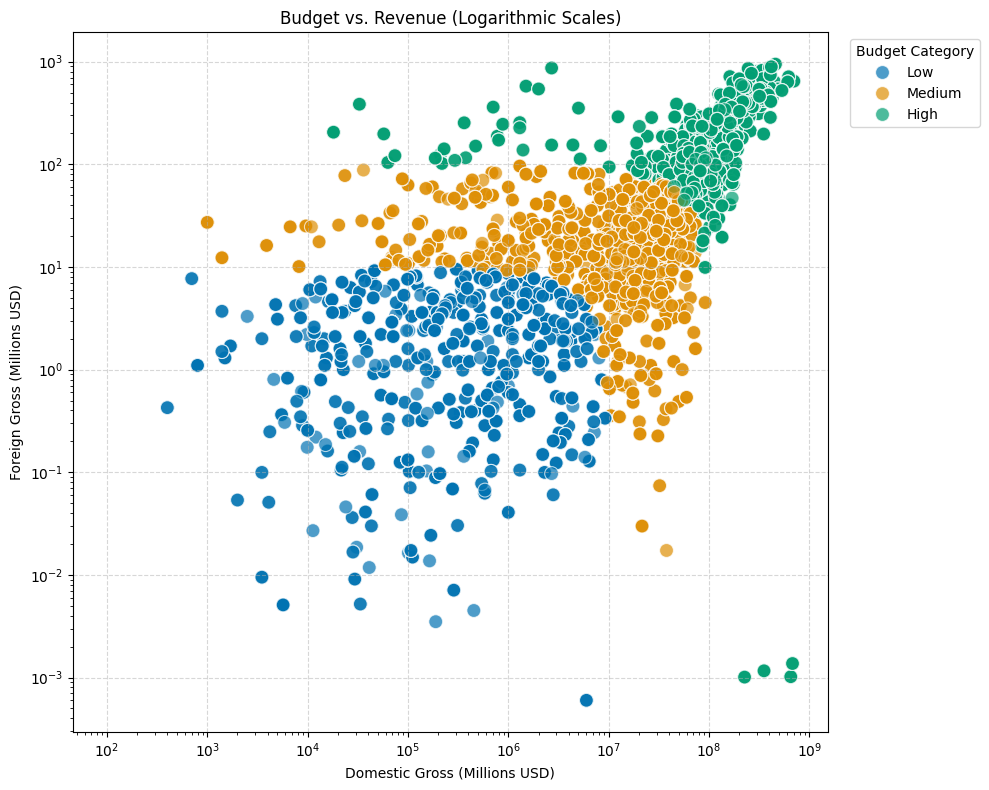

In [21]:
# Scatter plot for budget vs revenue
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=merged_data,
    x='domestic_gross',
    y=merged_data['foreign_gross'] / 1e6,
    hue='budget_category',
    palette='colorblind',
    alpha=0.7,
    s=100
)
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs. Revenue (Logarithmic Scales)')
plt.xlabel('Domestic Gross (Millions USD)')
plt.ylabel('Foreign Gross (Millions USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Budget Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


The scatter plot reveals that high-budget movies (green) generally achieve higher domestic and foreign grosses, indicating a positive correlation between budget and revenue. However, medium-budget (orange) and low-budget (blue) movies show a more diverse range of performance, with some achieving high grosses despite lower budgets.


### Movie Ratings vs. Total Gross

### 4.3. Do higher-rated movies make more money?

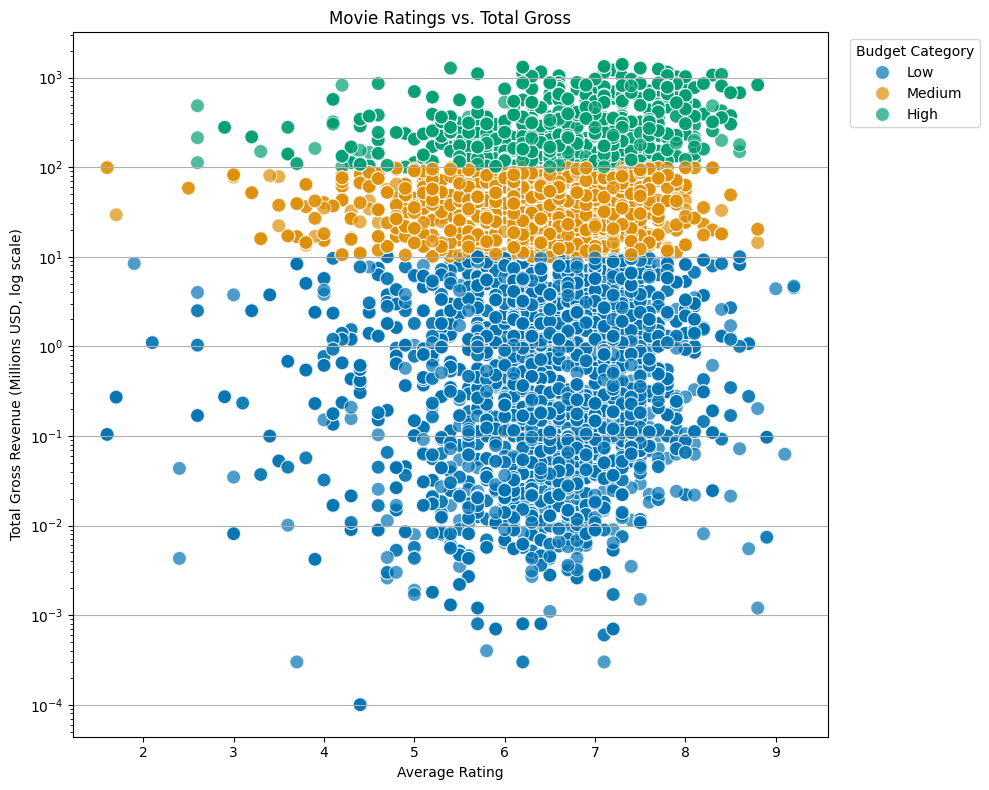

In [22]:
# Scatter plot for ratings vs gross
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=merged_data,
    x='averagerating',
    y=merged_data['total_gross'] / 1e6,
    hue='budget_category',
    palette='colorblind',
    alpha=0.7,
    s=100
)
plt.title('Movie Ratings vs. Total Gross')
plt.xlabel('Average Rating')
plt.ylabel('Total Gross Revenue (Millions USD, log scale)')
plt.yscale('log')
plt.grid(axis='y')
plt.legend(title='Budget Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Rating Analysis:

In [23]:
# Define rating categories
merged_data['rating_category'] = pd.cut(
    merged_data['averagerating'],
    bins=[0, 4, 6, 7, 8, 10],
    labels=['Poor', 'Average', 'Good', 'Very Good', 'Excellent']
)

In [24]:
# Calculate the average and median total gross revenue for each rating category
rating_summary = merged_data.groupby('rating_category')['total_gross'].agg(['mean', 'median']).sort_index()
rating_summary['mean'] /= 1e6  # Convert to millions
rating_summary['median'] /= 1e6  # Convert to millions

C:\Users\USER\AppData\Local\Temp\ipykernel_3752\354687364.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_summary = merged_data.groupby('rating_category')['total_gross'].agg(['mean', 'median']).sort_index()


### 4. Is there a rating threshold that significantly impacts a movie's financial success?

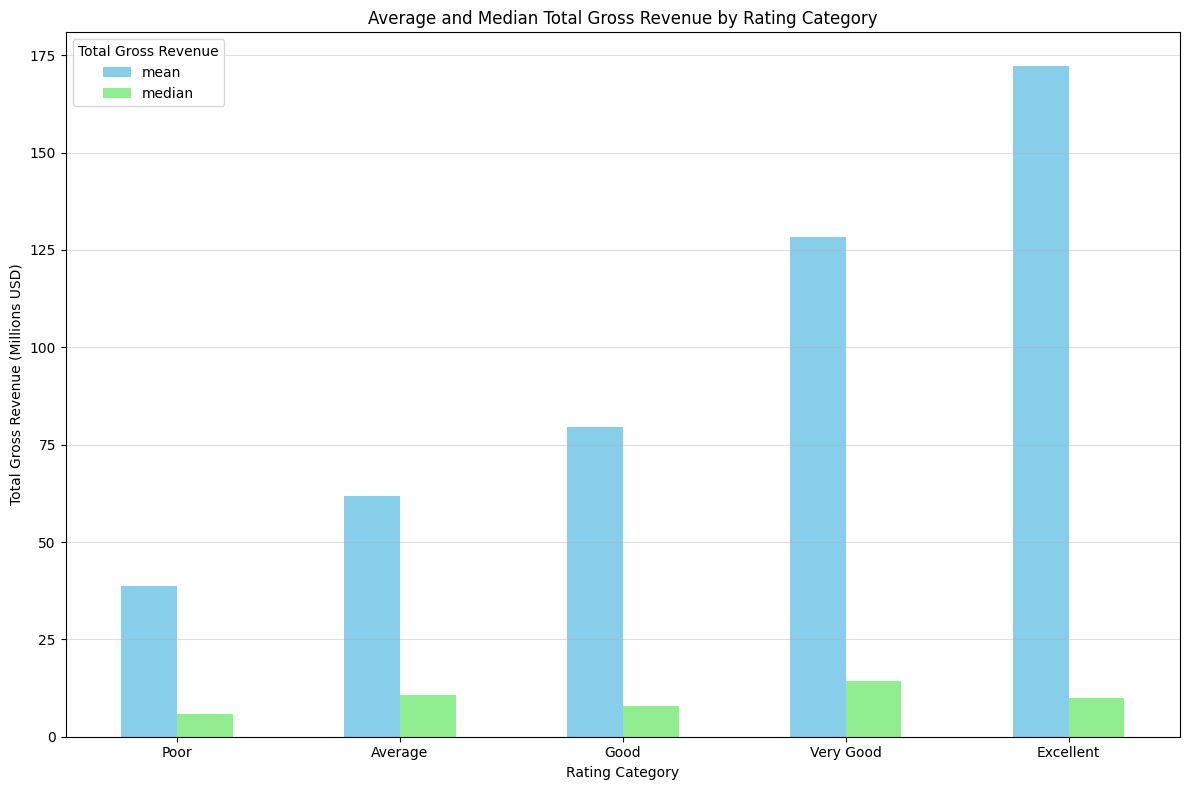

In [25]:
# Plot the average and median total gross revenue by rating category
plt.figure(figsize=(12, 8))
rating_summary.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightgreen'])
plt.title('Average and Median Total Gross Revenue by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Total Gross Revenue (Millions USD)')
plt.grid(axis='y', alpha=0.4)
plt.xticks(rotation=0)
plt.legend(title='Total Gross Revenue')
plt.tight_layout()
plt.show()

Insights:
Discrepancy Between Mean and Median:

For all rating categories, the mean revenue is significantly higher than the median revenue. This suggests that there are a few movies with extremely high revenues that are skewing the mean upwards.
Trend Across Ratings:

Both mean and median revenues tend to increase with higher ratings. Movies with better ratings ("Very Good" and "Excellent") tend to have much higher gross revenues on average compared to those with lower ratings.
Revenue Variability:

The large gap between mean and median values, especially in higher rating categories, indicates high variability in revenue. While a few movies may perform exceptionally well, the majority do not reach as high revenue figures.

#### How does the distribution of total gross revenue vary across different rating categories?

C:\Users\USER\AppData\Local\Temp\ipykernel_3752\1079556970.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


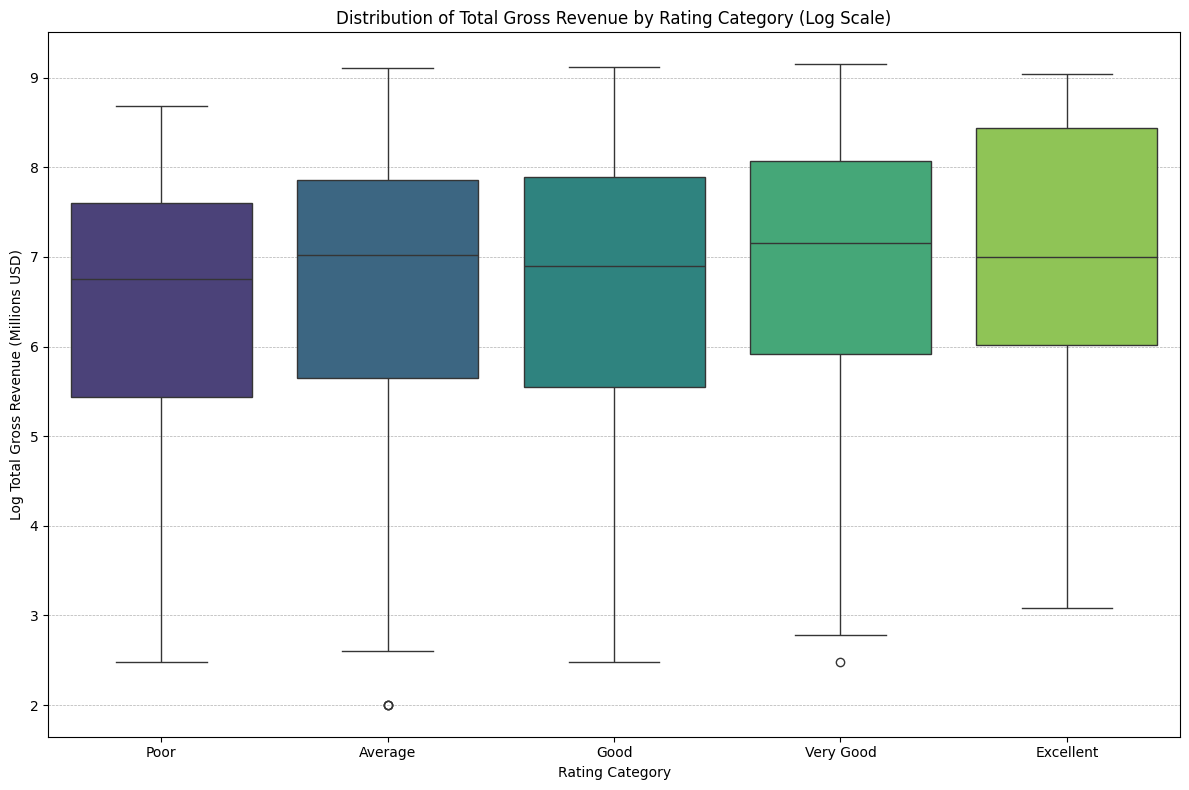

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='rating_category',
    y=np.log10(merged_data['total_gross'] + 1),  # Log scale to handle skewness
    data=merged_data,
    palette='viridis'
)
plt.title('Distribution of Total Gross Revenue by Rating Category (Log Scale)')
plt.xlabel('Rating Category')
plt.ylabel('Log Total Gross Revenue (Millions USD)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Insights:
Consistency Across Categories:

The medians are fairly consistent across categories, generally around 6 to 7 on the log scale.
Variability and Outliers:

Higher-rated categories ("Very Good" and "Excellent") exhibit a similar spread as lower-rated ones, though they also have outliers indicating some movies performed exceptionally poorly or well relative to their peers.
Revenue Spread:

The spread of revenue (as shown by the IQR) is fairly consistent across all rating categories, suggesting that variability in gross revenue is a common feature across all ratings.

## 5. Conclusions and Recommendations

### 5.1. Key Insights

**Most Lucrative Genres:**
 
- Action, Adventure, and Animation genres stand out as the top performers in terms of average box office revenue.
- These genres exhibit strong audience appeal and commercial success.

**Budget vs. Revenue:**
- Higher-budget movies generally generate more revenue.
- Notable outliers exist where low-budget films have performed exceptionally well, indicating strategic investment can lead to high returns.

**Ratings Impact:**
- Higher-rated movies tend to earn more revenue.
- The correlation between movie ratings and total gross suggests that quality content significantly impacts box office performance.
- This insight is supported by the scatter plot of movie ratings versus total gross.

**Revenue Distribution:**
- Action and Adventure genres tend to perform better internationally.
- Other genres display a more balanced or domestically skewed revenue distribution.
 


### 5.2. Actionable Recommendations

**Focus on Popular Genres:**
- Prioritize investment in Action, Adventure, and Animation genres due to their consistent performance.
- These genres should be the focus of future projects to maximize potential revenue.

**Balanced Budget:**

- Allocate budgets strategically.
- While high-budget projects often yield high revenue, incorporating lower-budget projects with high return potential can diversify financial risk.
- The budget vs. revenue graph highlights the importance of strategic budget allocation.

**Quality Over Quantity:**

- Aim for higher movie ratings to enhance success chances.
- Investing in quality production, compelling storytelling, and top talent can improve a movie's reception and its box office performance.
- The relationship between movie ratings and total gross revenue underscores the importance of focusing on quality.
